# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

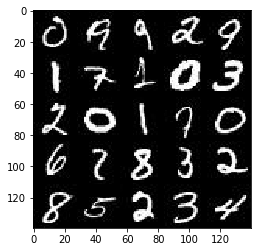

In [28]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

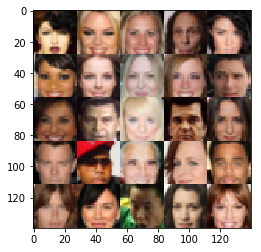

In [29]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [31]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [32]:
def discriminator(images, reuse=False):
    
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 256, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
def generator(z, out_channel_dim, is_train=True):
    alpha=0.2
    with tf.variable_scope('generator', reuse= not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim):
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
  
    smooth = 0.01
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [46]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars) 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [48]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    samples, losses = [], []
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
               
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 50, input_z, data_shape[3], data_image_mode)
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0830... Generator Loss: 4.6453
Epoch 1/2... Discriminator Loss: 0.0725... Generator Loss: 4.7948
Epoch 1/2... Discriminator Loss: 0.1055... Generator Loss: 11.8657
Epoch 1/2... Discriminator Loss: 5.2726... Generator Loss: 0.0169
Epoch 1/2... Discriminator Loss: 2.2245... Generator Loss: 0.9381
Epoch 1/2... Discriminator Loss: 1.7241... Generator Loss: 0.4491
Epoch 1/2... Discriminator Loss: 1.9751... Generator Loss: 0.2529
Epoch 1/2... Discriminator Loss: 1.7441... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 1.7857... Generator Loss: 0.3692
Epoch 1/2... Discriminator Loss: 1.9218... Generator Loss: 0.3484


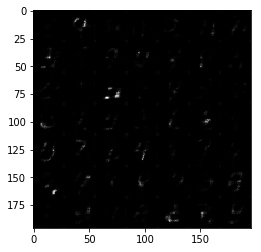

Epoch 1/2... Discriminator Loss: 1.7690... Generator Loss: 0.5183
Epoch 1/2... Discriminator Loss: 1.8521... Generator Loss: 0.3019
Epoch 1/2... Discriminator Loss: 1.8843... Generator Loss: 0.5595
Epoch 1/2... Discriminator Loss: 2.3501... Generator Loss: 0.2741
Epoch 1/2... Discriminator Loss: 2.0324... Generator Loss: 0.2714
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.7432... Generator Loss: 0.4045
Epoch 1/2... Discriminator Loss: 1.9192... Generator Loss: 0.2377
Epoch 1/2... Discriminator Loss: 1.6644... Generator Loss: 0.8135
Epoch 1/2... Discriminator Loss: 1.7942... Generator Loss: 0.2632


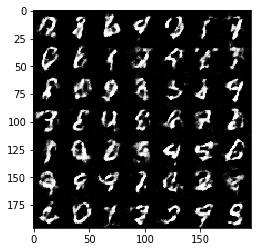

Epoch 1/2... Discriminator Loss: 1.5441... Generator Loss: 0.7215
Epoch 1/2... Discriminator Loss: 1.8086... Generator Loss: 0.4132
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.6322
Epoch 1/2... Discriminator Loss: 1.6798... Generator Loss: 0.5337
Epoch 1/2... Discriminator Loss: 1.5951... Generator Loss: 0.4497
Epoch 1/2... Discriminator Loss: 1.7735... Generator Loss: 0.4114
Epoch 1/2... Discriminator Loss: 1.8437... Generator Loss: 0.2431
Epoch 1/2... Discriminator Loss: 1.7334... Generator Loss: 0.4331
Epoch 1/2... Discriminator Loss: 1.5971... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.7382... Generator Loss: 0.3393


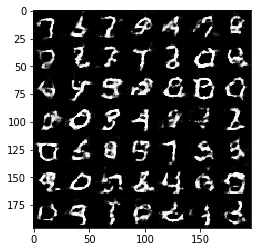

Epoch 1/2... Discriminator Loss: 1.7431... Generator Loss: 0.8733
Epoch 1/2... Discriminator Loss: 1.4661... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.7459... Generator Loss: 0.3095
Epoch 1/2... Discriminator Loss: 1.7146... Generator Loss: 0.2984
Epoch 1/2... Discriminator Loss: 1.4296... Generator Loss: 0.5799
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.5221
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.5695... Generator Loss: 0.9827
Epoch 1/2... Discriminator Loss: 1.5606... Generator Loss: 1.0142
Epoch 1/2... Discriminator Loss: 1.5798... Generator Loss: 0.3887


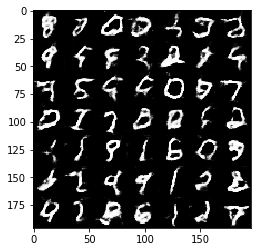

Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.7108
Epoch 1/2... Discriminator Loss: 1.7202... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 1.6308... Generator Loss: 1.3163
Epoch 1/2... Discriminator Loss: 1.7254... Generator Loss: 0.2761
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.5194
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.6335... Generator Loss: 0.3691
Epoch 1/2... Discriminator Loss: 1.4685... Generator Loss: 0.5344
Epoch 1/2... Discriminator Loss: 1.6432... Generator Loss: 0.3267


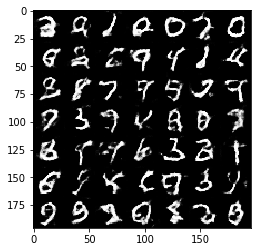

Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 0.4722
Epoch 1/2... Discriminator Loss: 1.4797... Generator Loss: 0.4210
Epoch 1/2... Discriminator Loss: 1.6046... Generator Loss: 0.3182
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 1.0881
Epoch 1/2... Discriminator Loss: 1.6197... Generator Loss: 0.3807
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 0.9684
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.4300
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.3863
Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 0.6488


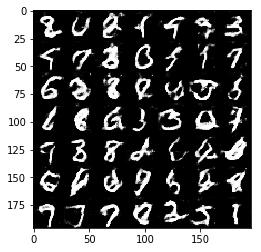

Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 1.0089
Epoch 1/2... Discriminator Loss: 1.5997... Generator Loss: 0.3579
Epoch 1/2... Discriminator Loss: 1.7061... Generator Loss: 1.4427
Epoch 1/2... Discriminator Loss: 1.8243... Generator Loss: 1.1279
Epoch 1/2... Discriminator Loss: 1.4820... Generator Loss: 0.4540
Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 0.9366
Epoch 1/2... Discriminator Loss: 1.7755... Generator Loss: 0.2416
Epoch 1/2... Discriminator Loss: 1.7446... Generator Loss: 0.2544
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.6454
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.6208


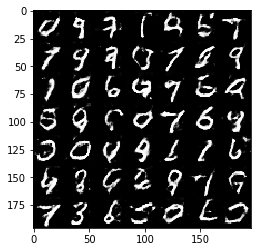

Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 1.4970... Generator Loss: 1.8576
Epoch 1/2... Discriminator Loss: 1.9080... Generator Loss: 0.2075
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 0.8915
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.6619... Generator Loss: 0.2848
Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 0.6919
Epoch 1/2... Discriminator Loss: 1.6354... Generator Loss: 0.3280
Epoch 1/2... Discriminator Loss: 1.8453... Generator Loss: 0.2367
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 0.6468


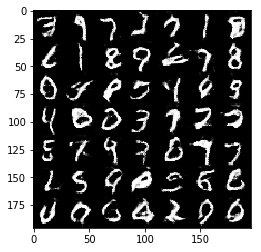

Epoch 1/2... Discriminator Loss: 1.4728... Generator Loss: 0.6210
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.8443
Epoch 1/2... Discriminator Loss: 1.5517... Generator Loss: 0.3738
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.6514
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 0.3764
Epoch 1/2... Discriminator Loss: 1.4896... Generator Loss: 0.4344
Epoch 1/2... Discriminator Loss: 1.7231... Generator Loss: 0.2632
Epoch 1/2... Discriminator Loss: 2.6640... Generator Loss: 0.1004
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 0.5391
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.5129


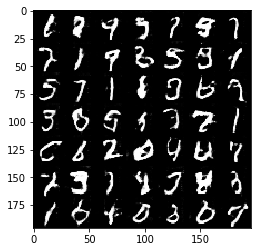

Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 0.9848
Epoch 1/2... Discriminator Loss: 1.6645... Generator Loss: 0.2851
Epoch 1/2... Discriminator Loss: 1.2686... Generator Loss: 0.5714
Epoch 2/2... Discriminator Loss: 2.1207... Generator Loss: 0.2004
Epoch 2/2... Discriminator Loss: 1.5089... Generator Loss: 0.4620
Epoch 2/2... Discriminator Loss: 1.5527... Generator Loss: 1.2173
Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.5035
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.4960
Epoch 2/2... Discriminator Loss: 1.6855... Generator Loss: 0.2701
Epoch 2/2... Discriminator Loss: 1.5993... Generator Loss: 0.3243


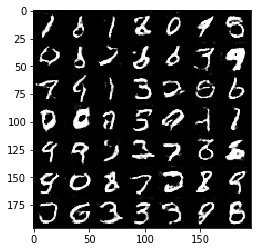

Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 1.4434
Epoch 2/2... Discriminator Loss: 0.7963... Generator Loss: 1.2222
Epoch 2/2... Discriminator Loss: 1.1274... Generator Loss: 0.6899
Epoch 2/2... Discriminator Loss: 1.8753... Generator Loss: 1.5342
Epoch 2/2... Discriminator Loss: 1.5770... Generator Loss: 0.3410
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.6445
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 0.4926
Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 1.7142
Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.8337
Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 0.5932


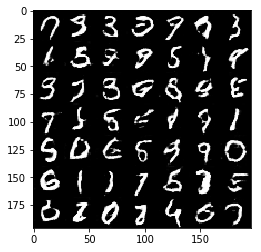

Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.6734
Epoch 2/2... Discriminator Loss: 1.5363... Generator Loss: 0.3323
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.6667
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.4109
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 1.2941
Epoch 2/2... Discriminator Loss: 1.2042... Generator Loss: 0.5302
Epoch 2/2... Discriminator Loss: 1.3374... Generator Loss: 0.4930
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 1.7410


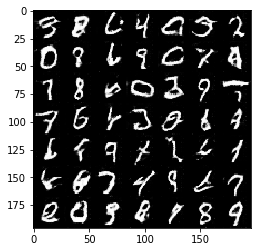

Epoch 2/2... Discriminator Loss: 1.4631... Generator Loss: 0.4653
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.5506
Epoch 2/2... Discriminator Loss: 1.3103... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 1.7137... Generator Loss: 0.2772
Epoch 2/2... Discriminator Loss: 1.6577... Generator Loss: 0.3193
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.4521
Epoch 2/2... Discriminator Loss: 1.7068... Generator Loss: 0.3209
Epoch 2/2... Discriminator Loss: 1.1916... Generator Loss: 0.7332
Epoch 2/2... Discriminator Loss: 0.9030... Generator Loss: 1.1805
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 0.6820


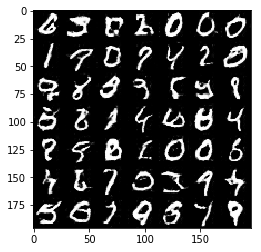

Epoch 2/2... Discriminator Loss: 1.5160... Generator Loss: 0.3226
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 1.1941
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 0.7714... Generator Loss: 1.2480
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.4376
Epoch 2/2... Discriminator Loss: 2.1561... Generator Loss: 0.1770
Epoch 2/2... Discriminator Loss: 1.5610... Generator Loss: 0.3755
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 0.5867
Epoch 2/2... Discriminator Loss: 1.7362... Generator Loss: 0.3283
Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.4400


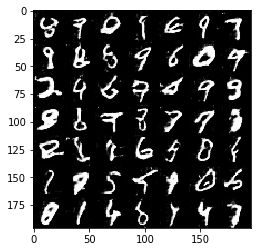

Epoch 2/2... Discriminator Loss: 1.0510... Generator Loss: 0.6653
Epoch 2/2... Discriminator Loss: 1.7926... Generator Loss: 0.2575
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 0.5984
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 2.3004... Generator Loss: 2.9126
Epoch 2/2... Discriminator Loss: 1.4012... Generator Loss: 0.6101
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 0.7468... Generator Loss: 3.0363
Epoch 2/2... Discriminator Loss: 1.9007... Generator Loss: 0.2574


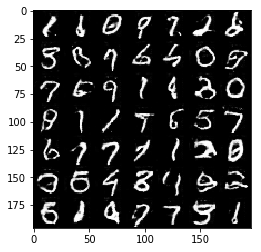

Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.6900
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.5477
Epoch 2/2... Discriminator Loss: 1.8730... Generator Loss: 0.2319
Epoch 2/2... Discriminator Loss: 1.5058... Generator Loss: 0.3384
Epoch 2/2... Discriminator Loss: 1.6677... Generator Loss: 0.2953
Epoch 2/2... Discriminator Loss: 0.9749... Generator Loss: 1.1900
Epoch 2/2... Discriminator Loss: 1.2187... Generator Loss: 1.2596
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.4995
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 1.2431
Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.4335


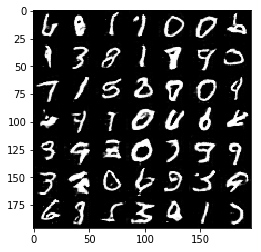

Epoch 2/2... Discriminator Loss: 1.5893... Generator Loss: 0.3114
Epoch 2/2... Discriminator Loss: 0.8947... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 1.4852... Generator Loss: 2.6147
Epoch 2/2... Discriminator Loss: 1.2848... Generator Loss: 1.2066
Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.3573
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 1.0256
Epoch 2/2... Discriminator Loss: 1.3254... Generator Loss: 0.4262
Epoch 2/2... Discriminator Loss: 1.4675... Generator Loss: 1.0294
Epoch 2/2... Discriminator Loss: 1.5126... Generator Loss: 0.4072
Epoch 2/2... Discriminator Loss: 1.1644... Generator Loss: 0.6093


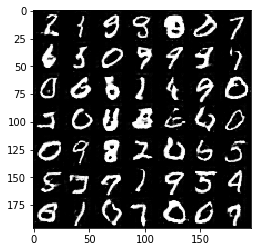

Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 0.5568
Epoch 2/2... Discriminator Loss: 2.2126... Generator Loss: 0.1563
Epoch 2/2... Discriminator Loss: 1.0968... Generator Loss: 2.0103
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 0.7568
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.4478
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 0.6094
Epoch 2/2... Discriminator Loss: 0.8252... Generator Loss: 1.1443
Epoch 2/2... Discriminator Loss: 1.6494... Generator Loss: 0.3268
Epoch 2/2... Discriminator Loss: 1.4297... Generator Loss: 0.4354


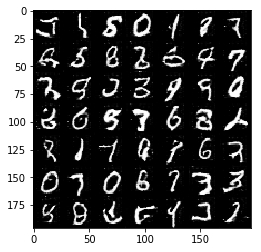

Epoch 2/2... Discriminator Loss: 1.2412... Generator Loss: 0.4753
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.5596
Epoch 2/2... Discriminator Loss: 1.5235... Generator Loss: 0.4083
Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 2.3560
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.5862
Epoch 2/2... Discriminator Loss: 1.5976... Generator Loss: 0.3052


In [49]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2275... Generator Loss: 6.7356
Epoch 1/1... Discriminator Loss: 3.0537... Generator Loss: 0.1086
Epoch 1/1... Discriminator Loss: 3.3693... Generator Loss: 0.0573
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 4.4681
Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 2.8992
Epoch 1/1... Discriminator Loss: 2.0104... Generator Loss: 5.6659
Epoch 1/1... Discriminator Loss: 3.4436... Generator Loss: 0.0446
Epoch 1/1... Discriminator Loss: 2.8286... Generator Loss: 0.0885
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.9604... Generator Loss: 0.4996


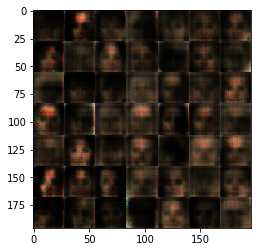

Epoch 1/1... Discriminator Loss: 1.7575... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 2.1396... Generator Loss: 0.2244
Epoch 1/1... Discriminator Loss: 1.9066... Generator Loss: 0.2682
Epoch 1/1... Discriminator Loss: 1.7103... Generator Loss: 0.3356
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.6487... Generator Loss: 0.3596
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.6696... Generator Loss: 0.3012


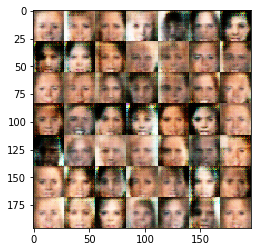

Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.6308... Generator Loss: 0.3891
Epoch 1/1... Discriminator Loss: 1.6580... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 2.0283... Generator Loss: 0.2250
Epoch 1/1... Discriminator Loss: 1.7008... Generator Loss: 0.3106
Epoch 1/1... Discriminator Loss: 2.1609... Generator Loss: 0.1865
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.4300
Epoch 1/1... Discriminator Loss: 1.7173... Generator Loss: 0.2660
Epoch 1/1... Discriminator Loss: 1.6245... Generator Loss: 0.2918
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.7696


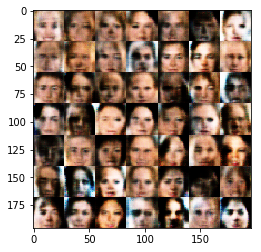

Epoch 1/1... Discriminator Loss: 2.1531... Generator Loss: 0.2096
Epoch 1/1... Discriminator Loss: 1.6023... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.5638
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.5864


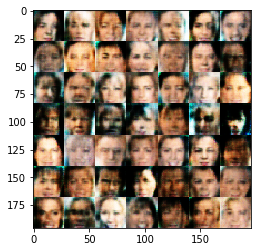

Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.7609
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.6999... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.4208
Epoch 1/1... Discriminator Loss: 1.7215... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.8531... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 0.4621


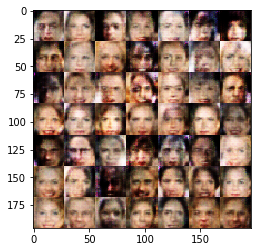

Epoch 1/1... Discriminator Loss: 1.6180... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.7040... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.4146
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.3661
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 1.1769


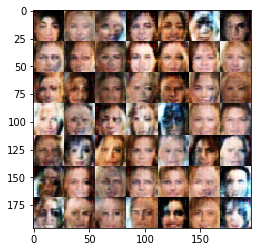

Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.6838... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.6259... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.4555
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.5026


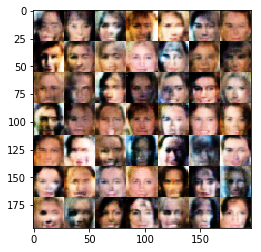

Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.4013
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.3271
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.7628... Generator Loss: 1.1277


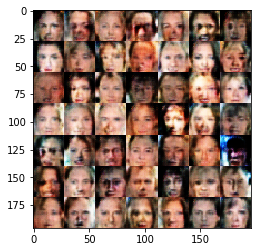

Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.4126
Epoch 1/1... Discriminator Loss: 1.7909... Generator Loss: 0.2589
Epoch 1/1... Discriminator Loss: 1.6282... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 2.0032... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 1.6748... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.7081


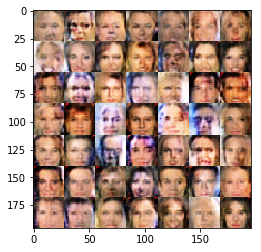

Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.6963... Generator Loss: 0.3356
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.5834... Generator Loss: 0.4506
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.9081


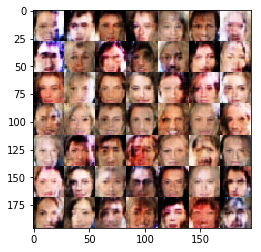

Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.3834
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.8592


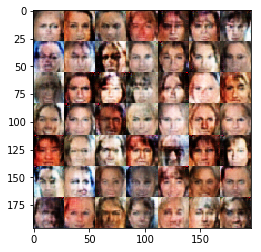

Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.3277
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.7225... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.6670... Generator Loss: 0.4367
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6293


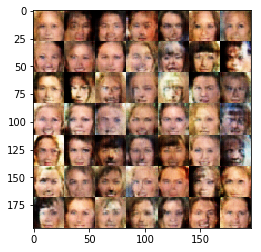

Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.6281... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.5994... Generator Loss: 0.3468
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.6496... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.6573... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.7184


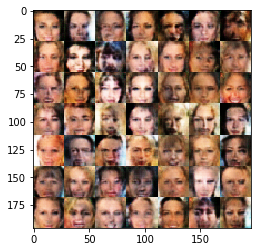

Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.6755... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.9230... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 1.7502... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.6292... Generator Loss: 0.6499


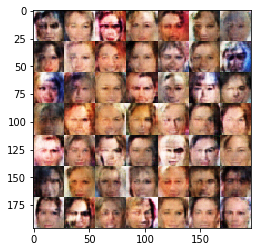

Epoch 1/1... Discriminator Loss: 1.6296... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.6256... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6649


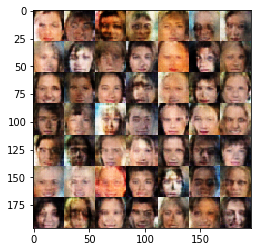

Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.5854


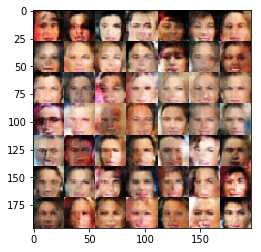

Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6841


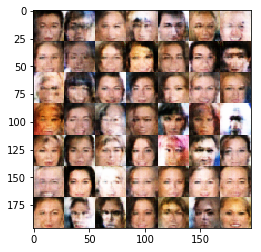

Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.6119... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.5934


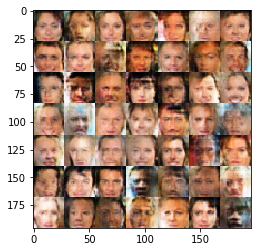

Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.6268... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.6694... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.5769... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7131


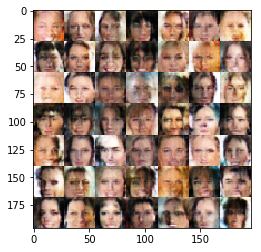

Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.6261... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.5994... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.5845


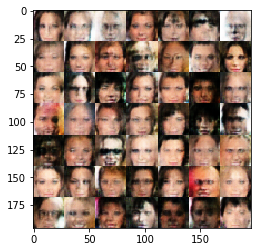

Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6453


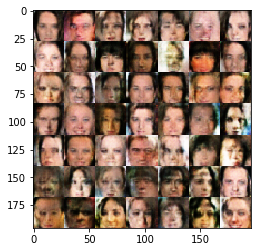

Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7121


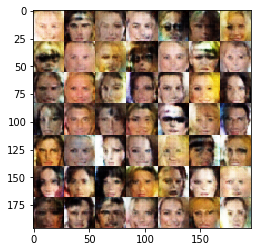

Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.5916


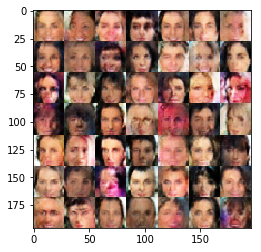

Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.6307... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.7579... Generator Loss: 0.3721
Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6275


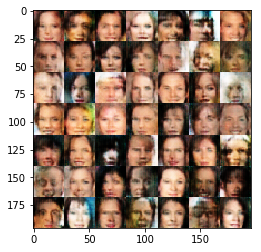

Epoch 1/1... Discriminator Loss: 1.7612... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.4303


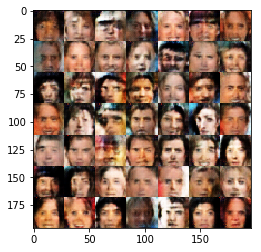

Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.4255
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6002


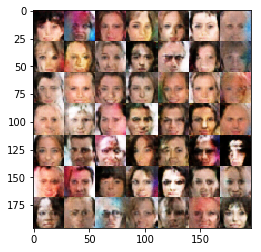

Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.4548
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 1.6053... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.6576... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.7890... Generator Loss: 0.2881


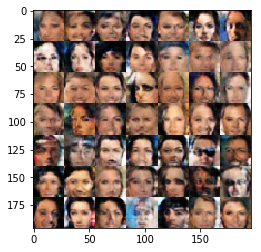

Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.4601


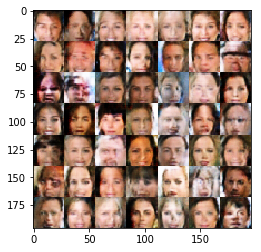

Epoch 1/1... Discriminator Loss: 1.6746... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.7116... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.6322... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.6598... Generator Loss: 0.3636
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.5467


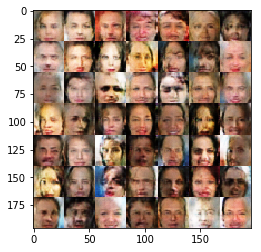

Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6064


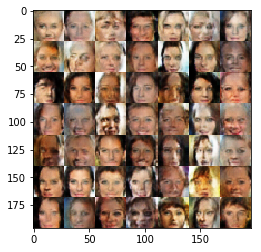

Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.5871... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.5272


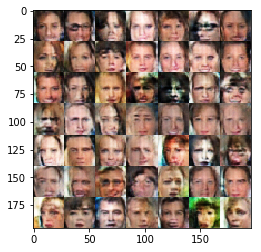

Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.5846... Generator Loss: 0.5908


In [50]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.